# Gaussian Process Regression with Noisy Sine Time Series
This notebook walks through how to perform Gaussian Process Regression with noisy sine time series data.  Data is generated by combining 
$$y(x) = sin(x) + \epsilon, \;\;\; \epsilon \sim \mathbb{N}(0, 0.5)$$
We will generate a Gaussian Process Regression model that estimates the mean and variance of $y(x_{*})$ given a set of observations.

## Import Block

In [2]:
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
import torch

## Create Dataset
Here, we'll create a dataset using NumPy `np.array` objects, and then will convert it to `torch.tensor` objects for use with PyTorch and GPyTorch.

In [ ]:
# Create features
X = torch.tensor(np.arange(100)).float()

# Create targets as noisy function of features
Y = torch.tensor(np.add(np.sin(X / 10), np.random.normal(loc=0, scale=0.5, size=100))).float()

## Define Model
Here, we'll use the GPyTorch API to define a Gaussian Process Regression model.  We'll use a `ConstantMean` function $m(x) = c$ for some $c \in \mathbb{R}$, and an outputscaled `MaternKernel` with discontinuity parameter $\nu = \frac{5}{2}$.

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, Y, likelihood)

## Optimization Loop
Here, we'll use the `torch` backend of GPyTorch to run optimization using gradient descent methods, such as, in this case, `Adam`.  Second-order optimization algorithms, such as `L-FBGS`, are also available.

In [ ]:
# this is for running the notebook in our testing framework
import os
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, Y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

## Noise-Free Predictions
Here, we can predict the model-free predictive distribution at test points $f(\mathbf{x}_{*})$.

In [ ]:
# Places model in "posterior mode"
model = model.eval()

# Create test data
X_test = torch.tensor(np.arange(0, 100, 0.01)).float()

# Makes predictions without noise
f_preds = model(X_test)

# Attributes of predictive function
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

## Make Predictions
We're now ready to make predictions with our model for $y(\mathbf{x}_{*})$.  Note the use of the `torch.no_grad()` context manager.  The second context manager, `gpytorch.settings.fast_pred_var()`, allows for fast variance prediction using LOVE.

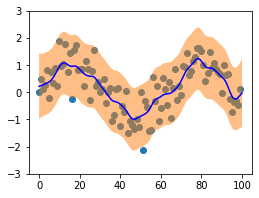

In [10]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.scatter(X.numpy(), Y.numpy())
    # Plot predictive means as blue line
    ax.plot(X_test.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])